<a href="https://colab.research.google.com/github/iamaarushi/ALY6110/blob/main/AY6110_Aarushi_M5Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Running Pyspark in Colab**

To run spark in Colab, You need proper setup. Next cell will create required setup for running Spark/PySpark:

In [1]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark


In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
#2> Read 'BostonHousing.csv' dataset in PySpark. You may use other dataset as well if you want to.

data_path = "BostonHousing.csv"  # Replace with the name of your CSV file

# Reading the CSV file into a DataFrame
data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(data_path)

# Showing the first few rows of the DataFrame
data.show(5)


+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [5]:
#3 > Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv')

from pyspark.ml.feature import VectorAssembler
input_cols = [col for col in data.columns if col != 'medv']

# Initialize the VectorAssembler
vec_assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Transform the DataFrame
data = vec_assembler.transform(data)

# DataFrame with the new 'features' column
data.select("features", "medv").show(5)


+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



In [6]:
#4> Standardize features for principal component analysis

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledataeatures")

# Compute summary statistics and generate the StandardScalerModel
scaler_model = scaler.fit(data)

# Normalize each feature
data = scaler_model.transform(data)

data.select("scaledataeatures", "medv").show(5)


+--------------------+----+
|    scaledataeatures|medv|
+--------------------+----+
|[7.34751712931429...|24.0|
|[0.00317501096205...|21.6|
|[0.00317268579840...|34.7|
|[0.00376327736512...|33.4|
|[0.00802762749650...|36.2|
+--------------------+----+
only showing top 5 rows



In [7]:
#5> Train model for two principal component analysis

from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="scaledataeatures", outputCol="pcaFeatures")
# Fit the PCA model to the data
pca_model = pca.fit(data)
# Transform the data
data = pca_model.transform(data)
# Show the DataFrame with the new 'pcaFeatures' column
data.select("pcaFeatures", "medv").show(5)


+--------------------+----+
|         pcaFeatures|medv|
+--------------------+----+
|[-1.2551263234672...|24.0|
|[-1.8955383642584...|21.6|
|[-1.2788028017576...|34.7|
|[-0.7424275948415...|33.4|
|[-0.8955945817747...|36.2|
+--------------------+----+
only showing top 5 rows



In [8]:
#6> collect distributed data in numpy array and then convert to pandas dataframe
import numpy as np
import pandas as pd
pca_features = np.array(data.select("pcaFeatures").rdd.flatMap(lambda x: x).collect())
medv = np.array(data.select("medv").rdd.flatMap(lambda x: x).collect())

# Convert the numpy arrays to a pandas DataFrame
data_pandas = pd.DataFrame(pca_features, columns=["PC1", "PC2"])
data_pandas["medv"] = medv

print(data_pandas.head())


        PC1       PC2  medv
0 -1.255126  0.619209  24.0
1 -1.895538  0.438260  21.6
2 -1.278803  0.445907  34.7
3 -0.742428 -0.160003  33.4
4 -0.895595 -0.055524  36.2


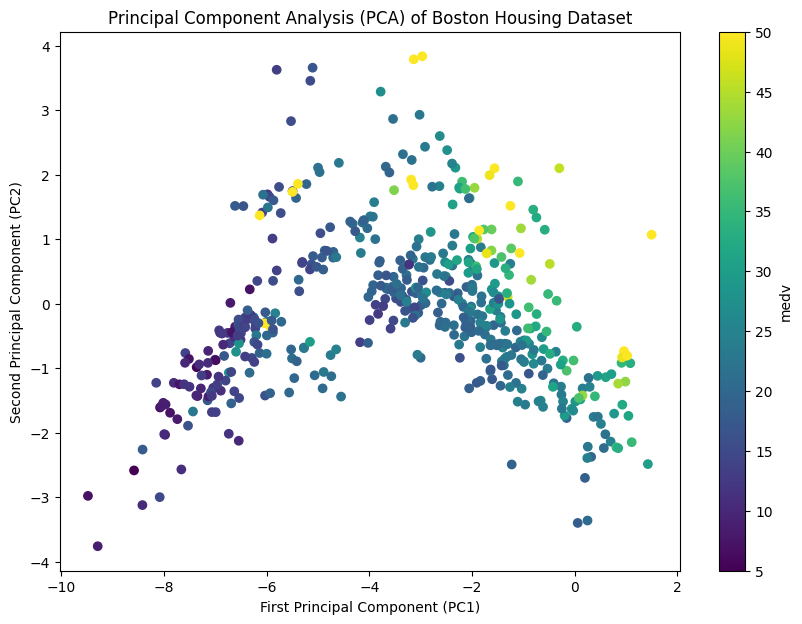

In [16]:
#7> Plot two principal components

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(data_pandas["PC1"], data_pandas["PC2"], c=data_pandas["medv"])
plt.colorbar(label='medv')
plt.xlabel('First Principal Component (PC1)')
plt.ylabel('Second Principal Component (PC2)')
plt.title('Principal Component Analysis (PCA) of Boston Housing Dataset')
plt.show()


In [18]:
#8> Vectorize features and target together for model development #9> Split the data into training and test sets
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
(trainingData, testData) = data.randomSplit([0.7, 0.3])
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))


Training Dataset Count: 375
Test Dataset Count: 131


In [20]:
#10> Fit model for linear regression and
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='pcaFeatures', labelCol='medv')
# Fit the model to the training data
lr_model = lr.fit(trainingData)


In [21]:
#11> Find out model coefficients and intercept

# Print the coefficients
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Coefficients: [2.2758945799952808,2.0523099526669513]
Intercept: 30.356186667650523


In [22]:
#12> Evaluate model for test dataset
result = lr_model.evaluate(testData)

# Print the root mean squared error (RMSE)
print("Root Mean Squared Error (RMSE) on test data: %f" % result.rootMeanSquaredError)

# Print the R-squared value
print("R Squared (R2) on test data: %f" % result.r2)


Root Mean Squared Error (RMSE) on test data: 7.431119
R Squared (R2) on test data: 0.422426


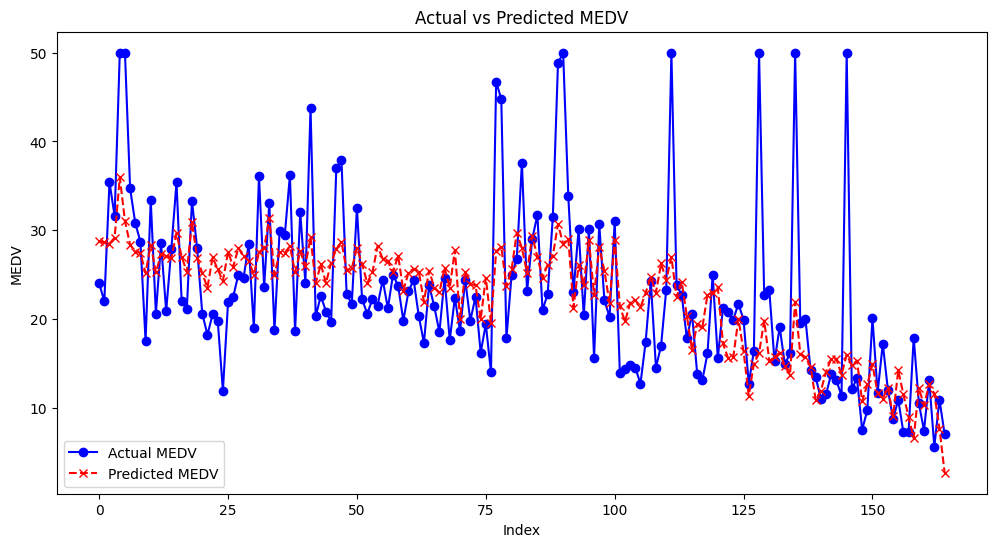

In [29]:
# Create a line plot for actual vs predicted values
import matplotlib.pyplot as plt
predictions = lr_model.transform(testData)
predictions_df = predictions.select("prediction", "medv").toPandas()  # Change 'label' to 'medv'

plt.figure(figsize=(12, 6))
plt.plot(predictions_df["medv"], label="Actual MEDV", color='blue', linestyle='-', marker='o')  # Change 'label' to 'medv'
plt.plot(predictions_df["prediction"], label="Predicted MEDV", color='red', linestyle='--', marker='x')
plt.xlabel("Index")
plt.ylabel("MEDV")
plt.title("Actual vs Predicted MEDV")
plt.legend()
plt.show()

